2024-04-02 10:59:33.435481: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 10:59:33.435537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 10:59:33.437556: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 10:59:33.678938: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 10:59:35.749271: W tensorflow/compiler/

4/4 [==============================] - 0s 2ms/step


2024-04-02 10:59:41.020003: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-02 10:59:41.443590: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f400526e5b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-02 10:59:41.443639: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-04-02 10:59:41.456573: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-02 10:59:41.494870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-04-02 10:59:41.587887: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 [==============================] - 0s 2ms/step
Epoch 1/200, d_loss: 0.5664, g_loss: 1.3081
4/4 [==============================] - 0s 3ms/step
Epoch 2/200, d_loss: 0.6640, g_loss: 1.2421
4/4 [==============================] - 0s 2ms/step
Epoch 3/200, d_loss: 0.6077, g_loss: 1.1556
4/4 [==============================] - 0s 3ms/step
Epoch 4/200, d_loss: 0.5283, g_loss: 1.1517
4/4 [==============================] - 0s 2ms/step
Epoch 5/200, d_loss: 0.4969, g_loss: 1.2526
4/4 [==============================] - 0s 2ms/step
Epoch 6/200, d_loss: 0.5335, g_loss: 1.0552
4/4 [==============================] - 0s 2ms/step
Epoch 7/200, d_loss: 0.6201, g_loss: 1.1348
4/4 [==============================] - 0s 2ms/step
Epoch 8/200, d_loss: 0.6519, g_loss: 1.0398
4/4 [==============================] - 0s 2ms/step
Epoch 9/200, d_loss: 0.6133, g_loss: 1.0910
4/4 [==============================] - 0s 2ms/step
Epoch 10/200, d_loss: 0.5238, g_loss: 1.1189
4/4 [==============================] - 0s 2ms/ste

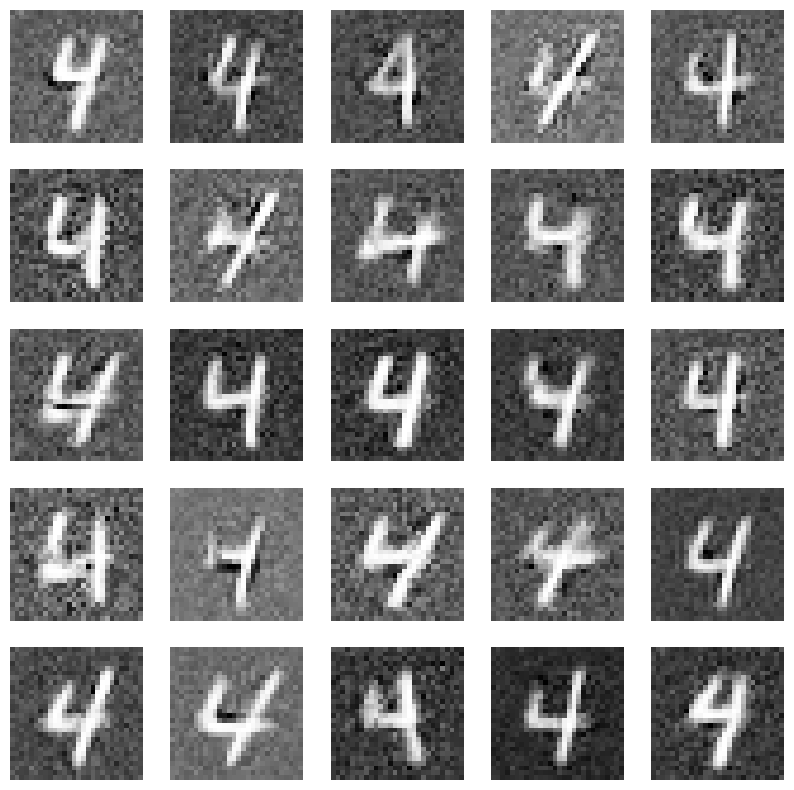

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (_, _) = mnist.load_data()

# Normalize pixel values
x_train = x_train.astype('float32') / 255

# Filter out digits 1 and 9
indices_1 = np.where(y_train == 4)[0]
x_train = x_train[indices_1]

# Reshape data
x_train = np.expand_dims(x_train, axis=-1)

# Hyperparameters
latent_dim = 100
batch_size = 128
epochs = 200

# Generator model
generator_input = Input(shape=(latent_dim,))
x = Dense(256, activation=LeakyReLU(alpha=0.2))(generator_input)
x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
x = Dense(784, activation='tanh')(x)
x = Reshape((28, 28, 1))(x)
generator = Model(generator_input, x)

# Discriminator model
discriminator_input = Input(shape=(28, 28, 1))
x = Flatten()(discriminator_input)
x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
x = Dense(1, activation='sigmoid')(x)
discriminator = Model(discriminator_input, x)

# Compile discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Combined model for training the generator
discriminator.trainable = False
z = Input(shape=(latent_dim,))
generated_img = generator(z)
validity = discriminator(generated_img)
combined = Model(z, validity)

# Compile combined model
combined.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Training loop
for epoch in range(epochs):
    for batch in range(x_train.shape[0] // batch_size):
        # Sample real images
        real_images = x_train[batch * batch_size:(batch + 1) * batch_size]

        # Sample noise for generator
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))

        # Generate fake images
        generated_images = generator.predict(noise)

        # Train discriminator
        real_output = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
        fake_output = discriminator.train_on_batch(generated_images, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(real_output, fake_output)

        # Train generator
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

    # Print losses and generate sample images every epoch
    print(f"Epoch {epoch+1}/{epochs}, d_loss: {d_loss:.4f}, g_loss: {g_loss:.4f}")


# Generate sample images
noise = np.random.normal(0, 1, size=(25, latent_dim))
generated_samples = generator.predict(noise)

# Plot sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(generated_samples[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

In [1]:
# Generate a single sample image
noise = np.random.normal(0, 1, size=(1, latent_dim))
generated_sample = generator.predict(noise)[0, :, :, 0]

# Plot single sample image
plt.figure(figsize=(1, 1))
plt.imshow(generated_sample, cmap='gray')
plt.axis('off')
plt.show()

NameError: name 'np' is not defined

4/4 [==============================] - 0s 3ms/step


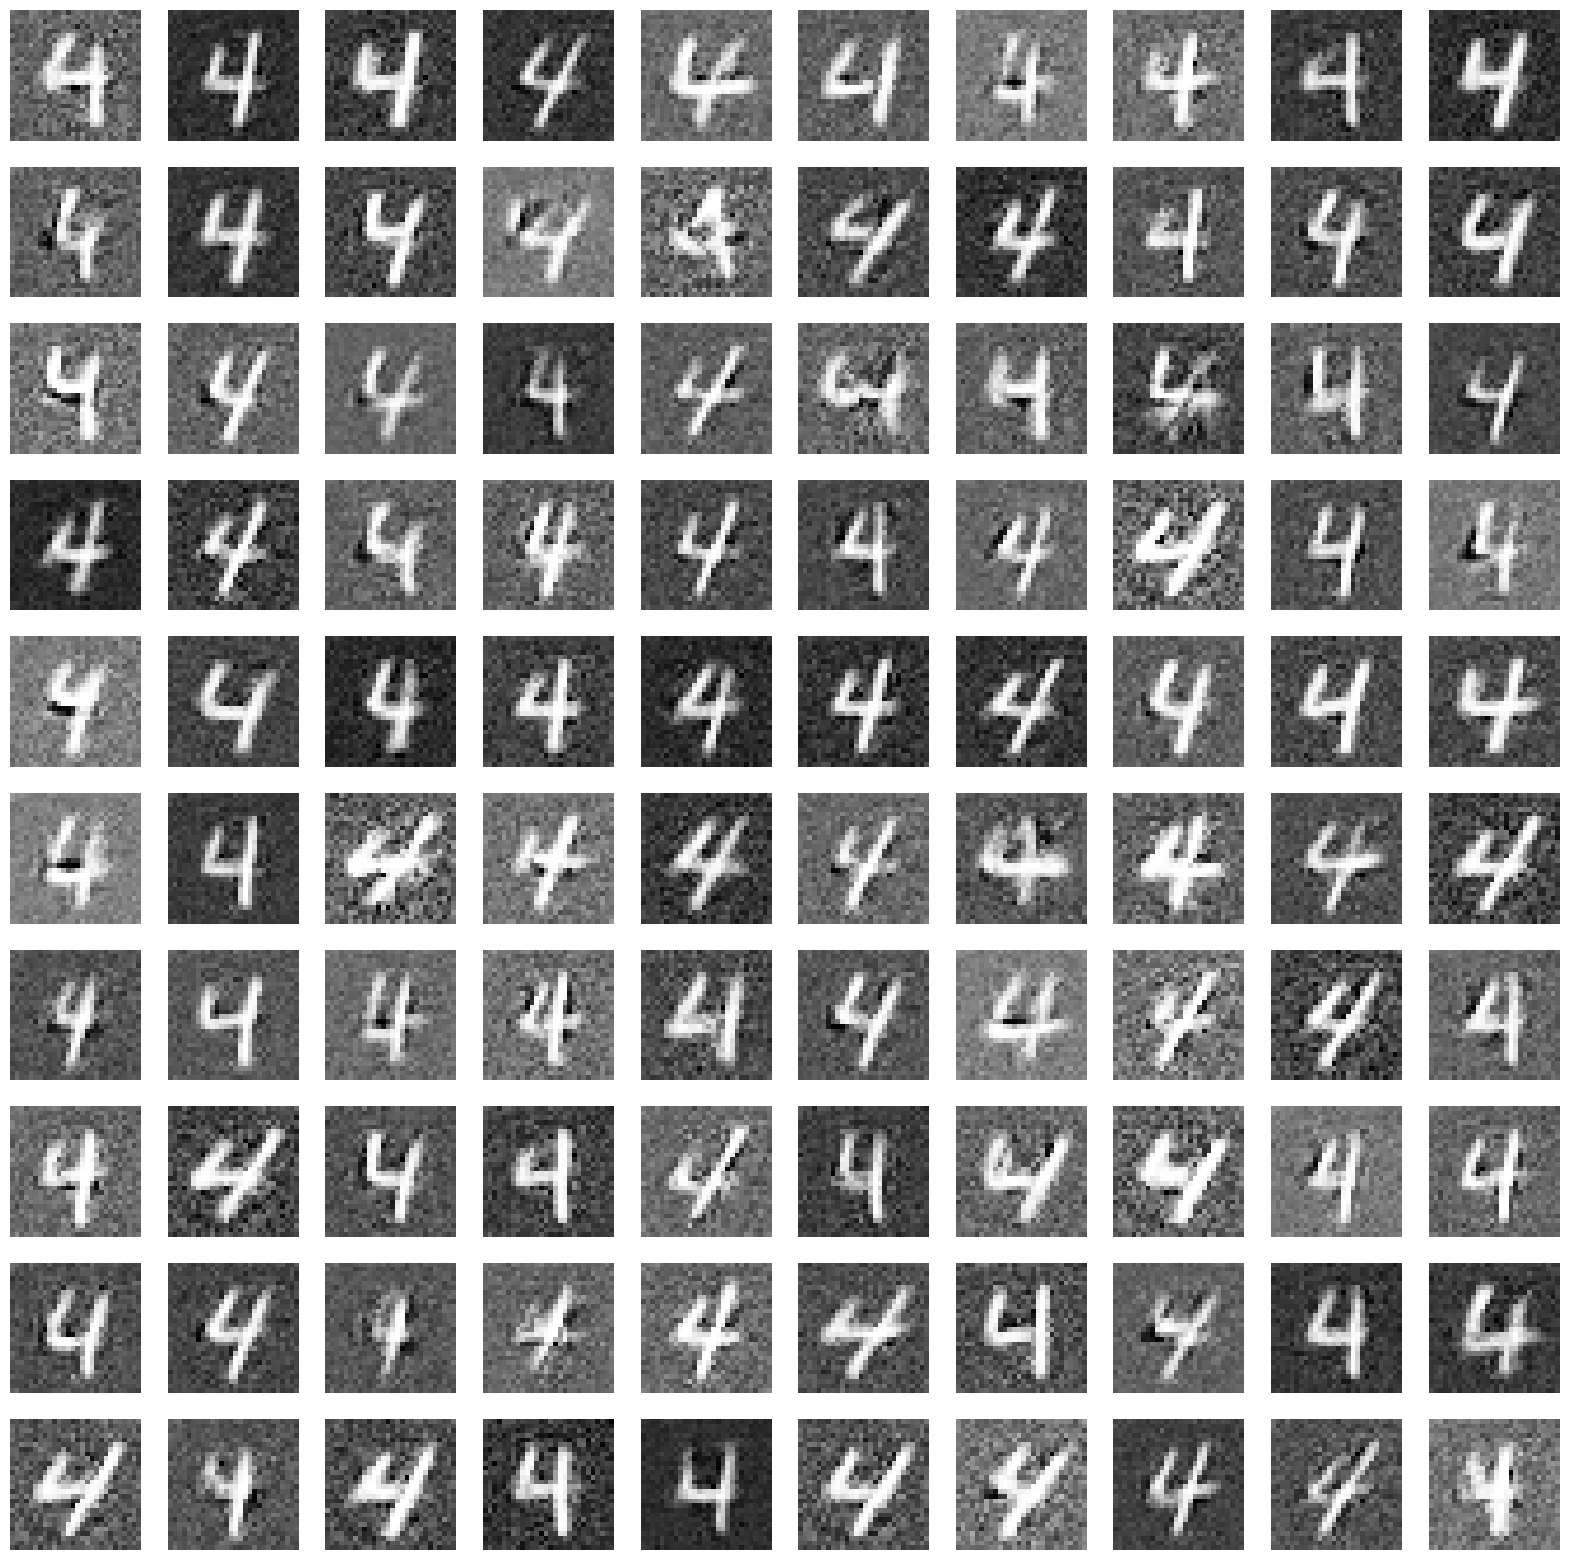

In [163]:
# Generate sample images
noise = np.random.normal(0, 1, size=(100, latent_dim))
generated_samples = generator.predict(noise)

# Plot sample images
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_samples[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

In [3]:
# Save model
generator.save('gan_generator.h5')
discriminator.save('gan_discriminator.h5')
combined.save('gan_combined.h5')

/home/sreeman/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [164]:
# Save the hyperparameters
np.save('gan_hyperparameters.npy', [latent_dim, batch_size, epochs])

: 